# code to produce diurnal cycle of temperature, humidity, lhf and shf
#### author: Claudia Acquistapace 
#### date: 16 Nov 2021
#### 

### Definition of the libraries and the variables

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths for plots and data files
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/arthus_diurnal_cycle/'

dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}


# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]

def f_clean_lidar_signal_from_noise_v1(data_path, dict_var, noise_mask_file):
    '''
    date: 24/11/2021
    author: Claudia Acquistapace
    goal: apply to the data the following filters:
    - filter to nans the values out of the threshold values
    - remove signal above cloud base
    input: 
        data_path: string containing the path to the ncdf files of the arthus lidar system
        dict_var : dictionary of settings specific of the variable of interest 
        noise_mask_file: filename including the path of the noise_mask file containing the cloud base height used for the filtering
    output: arthus_data_interp. Xarray dataset containing the variables without the noise
    note: this version of the function (v1) reads the entire dataset at once.
    For a function working on a single day, check V2
    '''
    arthus_files = np.sort(glob.glob(data_path+'*.cdf'))

    # merging data from each day in a single xarray dataset
    arthus_data = xr.open_mfdataset(arthus_files)


    # removing time duplicates for LHF and SHF file
    if (dict_var['var_name'] == 'LHF') | (dict_var['var_name'] == 'SHF'):
        _, index = np.unique(arthus_data['Time'], return_index=True)
        arthus_data = arthus_data.isel(Time=index)
        print('removed duplicates of time stamps')
        
        
    # set to nan the values out of the thresholds for the selected variable
    mask = (arthus_data["Product"].values > dict_var['thr_min']) & (arthus_data["Product"].values < dict_var['thr_max'])
    arthus_data["nans"] = xr.full_like(arthus_data.Product, fill_value=np.nan)
    arthus_data['Product'] = xr.where(mask, arthus_data['Product'], arthus_data["nans"])
    
    
    # opening noise mask file to read cloud base
    noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
    noise_mask = xr.open_dataset(noise_mask_file)
    cloud_base = noise_mask.cloud_base_height.values


    # interpolating time of the arthus product (T,WVMR, LHF, SHF) on the time of the noise mask (BR ratio time res)
    arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

    # find closest height of arthus data to the threshold height for every time stamp
    arthus_height_thr = []
    for ind_t in range(len(arthus_data_interp.Time.values)):
        arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, cloud_base[ind_t])])    


    # building noise mask for arthus_data
    mask = np.ones((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
    for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
        ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
        mask[ind,ind_zero[0]] = 0.
        

    # applying the mask to the product variable
    arthus_data_interp["nans"] = xr.full_like(arthus_data_interp.Product, fill_value=np.nan)
    arthus_data_interp['Product'] = xr.where(mask, arthus_data_interp['Product'], arthus_data_interp["nans"])
    
    return(arthus_data_interp)


def f_calc_diurnal_cycle(arthus_data_interp, dict_var, path_out):
    '''
    date: 24/11/2021
    author: Claudia Acquistapace
    input: 
        arthus_data_interp: xarray dataset containing the data over which to calculate diurnal cycle
        dict_var : dictionary of settings specific of the variable of interest 
        path_out: output path for the ncdf file containing the diurnal cycle

    goal: calculate the diurnal cycle of the input variable and save it in ncdf. The time resolution for the diurnal
    cycle is stored in dict_var['avg_time'] and depends on the variable to process.
    
    '''
    # calculating the mean of the variable over the time interval requested
    arthus_data_interp = arthus_data_interp.resample(Time=dict_var['avg_time']+'T').mean()

    # re-writing time array as hh:mm for then being able to group
    arthus_data_interp['Time'] = pd.to_datetime(arthus_data_interp.Time.values).strftime("%H:%M")

    # grouping and calculating mean of the profiles
    grouped_mean = arthus_data_interp.groupby('Time').mean()
    grouped_std = arthus_data_interp.groupby('Time').std()
    
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \
                                 grouped_mean['Product'].values.T, vmin=dict_var['var_min'], \
                                 vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                            location='right', aspect=20, use_gridspec=grid)
    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
                fontweight='black', transform=axs.transAxes)
    
    # saving diurnal cycle in ncdf file
    dims             = ['Time','Height']
    coords           = {"Time":pd.to_datetime(grouped_mean['Time'].values), "Height":grouped_mean['Height'].values}
    diurnal_cycle       = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['Product'].values,\
                         attrs={'long_name':'diurnal cycle over '+dict_var['avg_time']+'min for '+dict_var['var_string'],\
                                'units':dict_var['var_units']})
    global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'AUTHOR_NAME'          : 'Claudia Acquistapace',
                        'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'diurnal cycle of the variable '+dict_var['var_string']+'calculated over '+dict_var['avg_time']+'minutes',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
    dataset    = xr.Dataset(data_vars = {'diurnal_cycle':diurnal_cycle},
                                      coords = coords,
                                       attrs = global_attributes)
    dataset.to_netcdf(path_out+dict_var['var_name']+'_diurnal_cycle.nc')
    return(dataset)

removed duplicates of time stamps
removed duplicates of time stamps


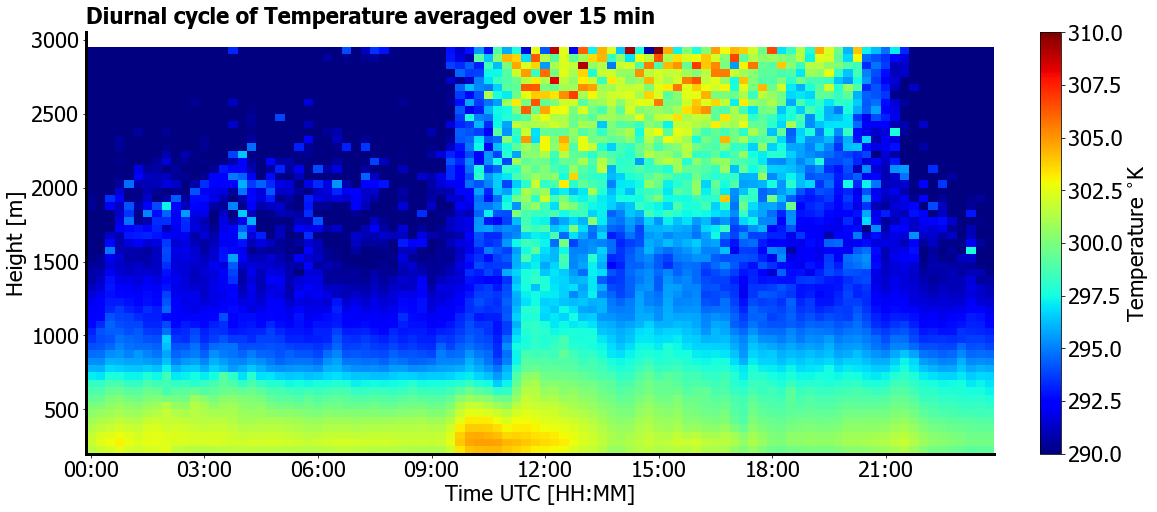

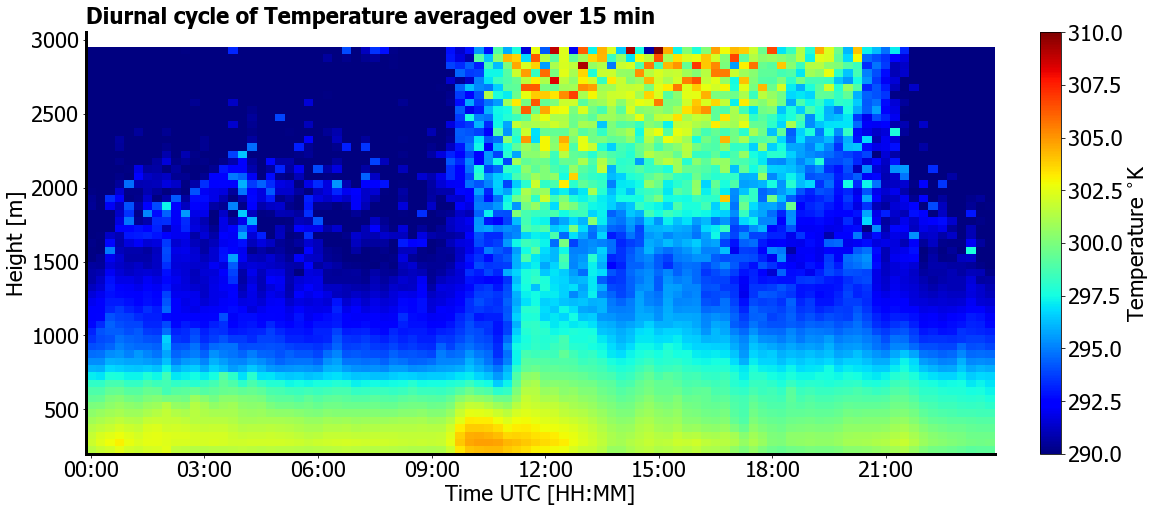

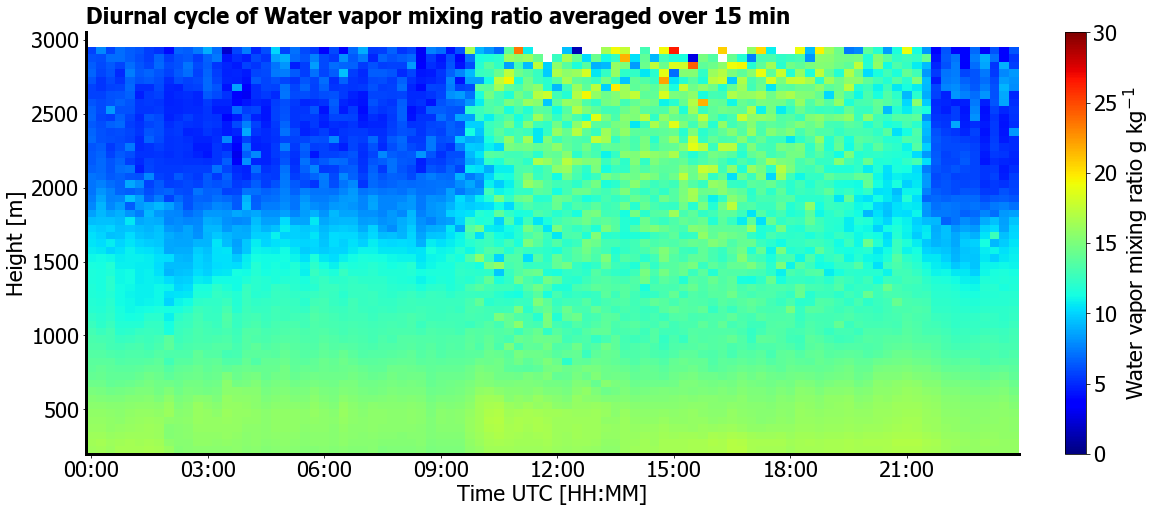

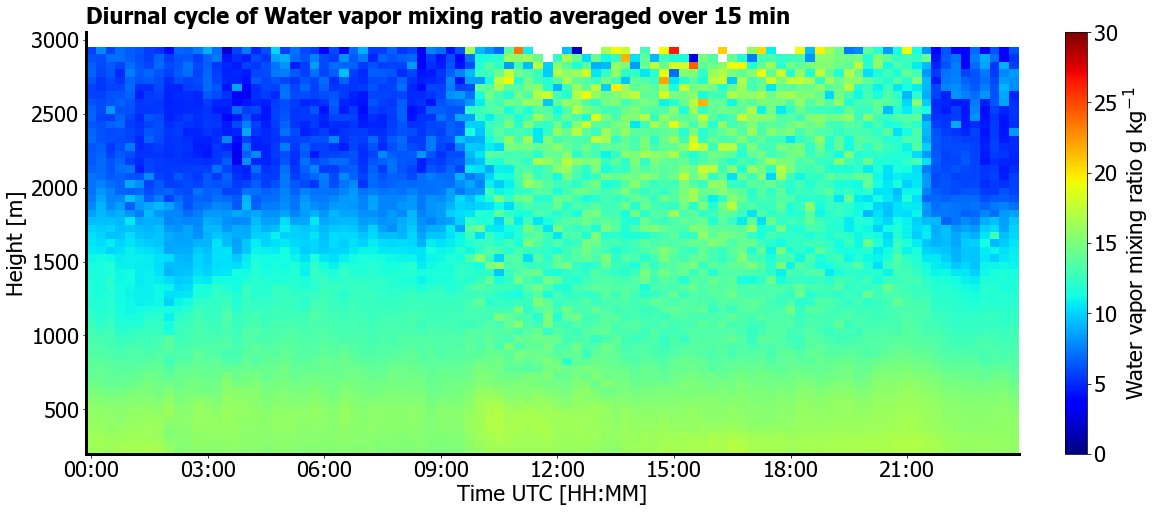

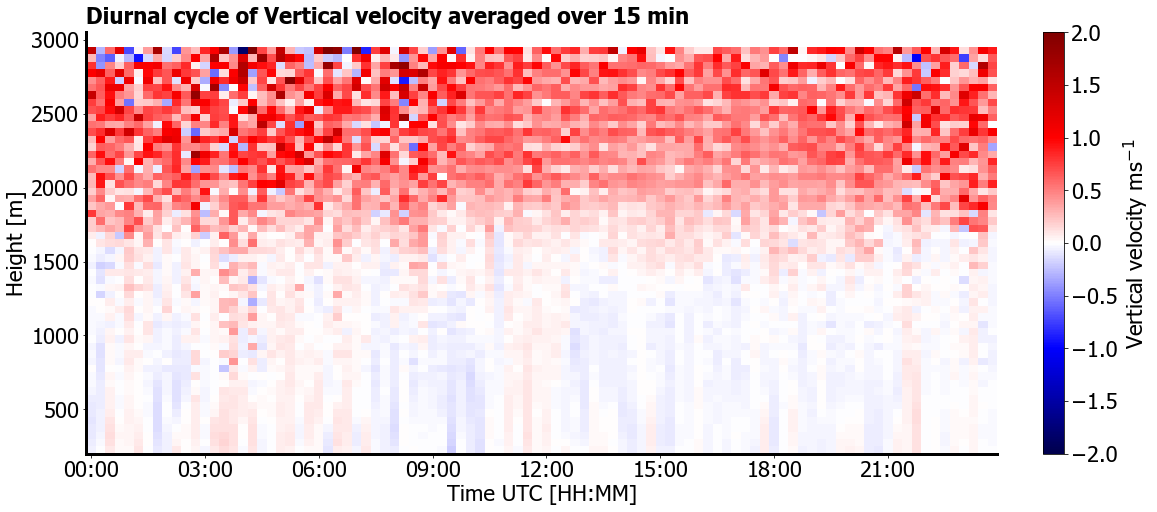

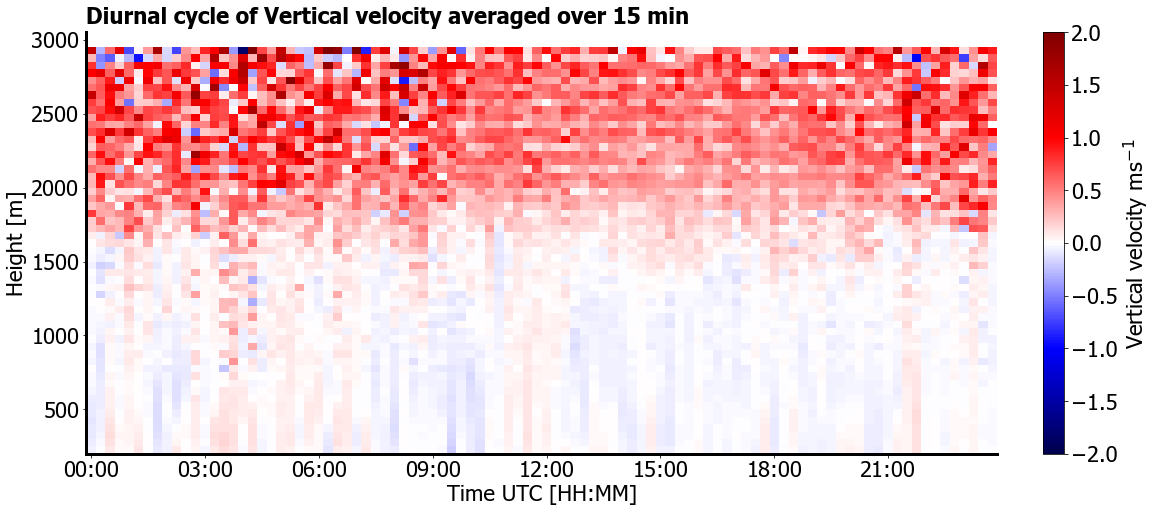

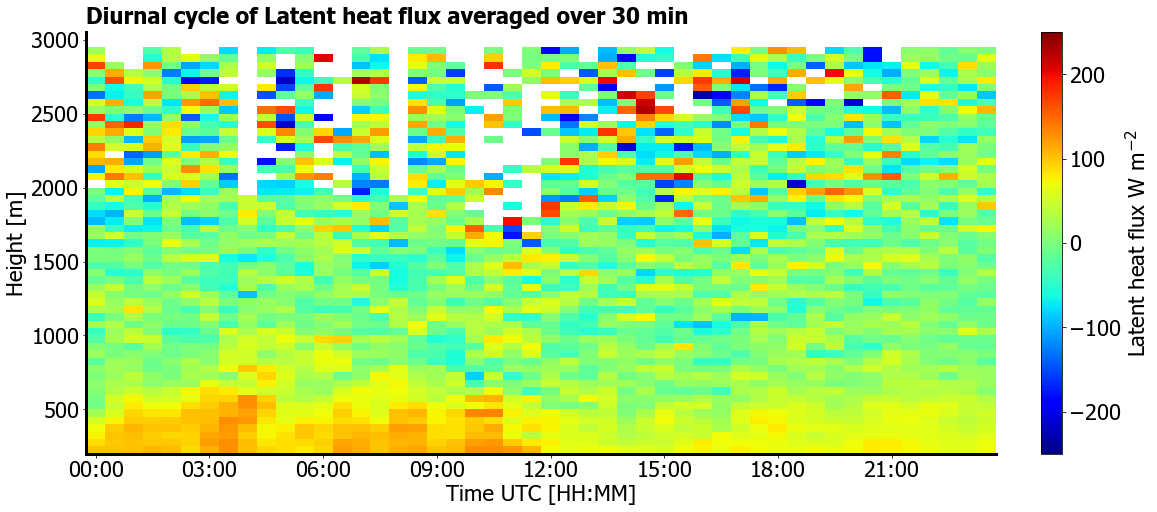

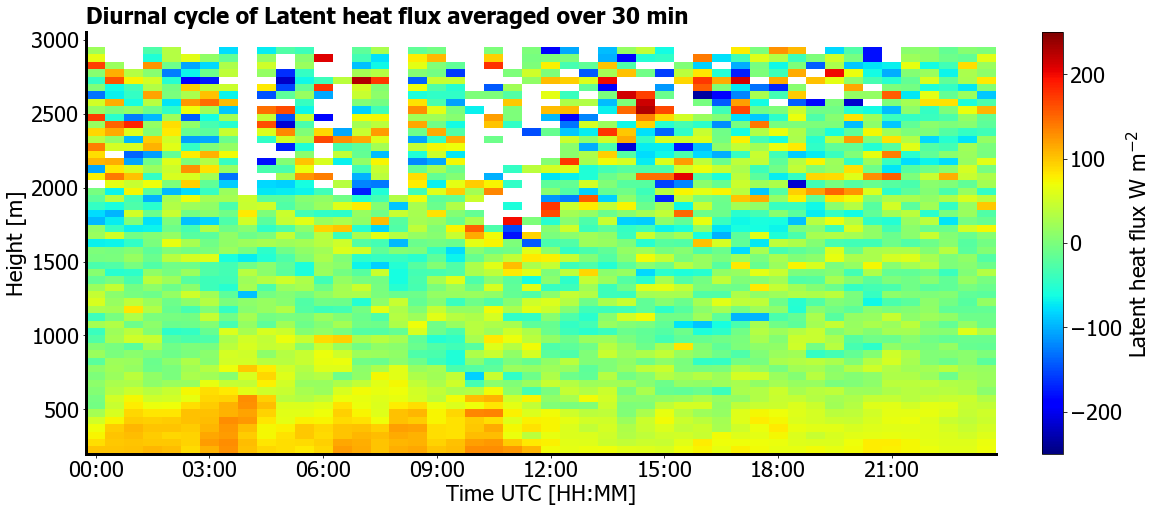

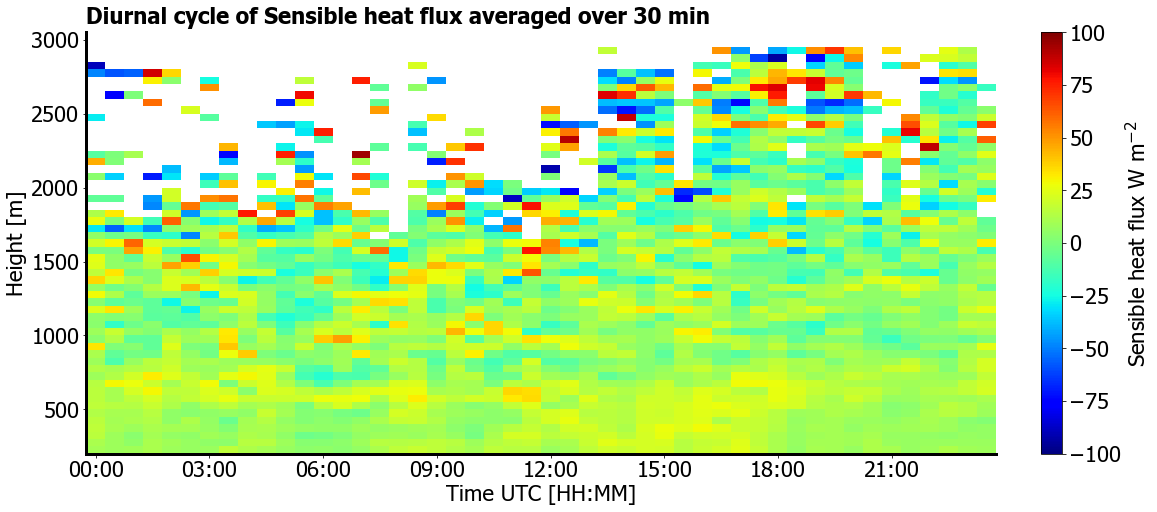

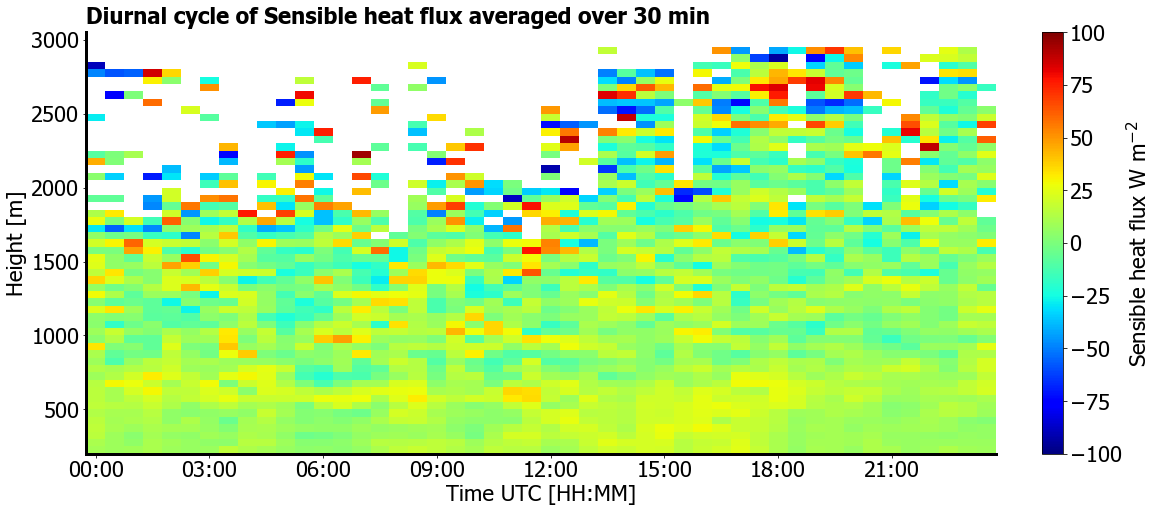

In [4]:
# testing the function 
dict_var = T_dict
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'

for i_dict, dict_var in enumerate(dict_list):
    
    # reading the data and removing outliers and pixels above cloud base
    data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'
    arthus_no_noise = f_clean_lidar_signal_from_noise_v1(data_path, dict_var, noise_mask_file)
    
    # calculating diurnal cycle using the function above
    d_cycle = f_calc_diurnal_cycle(arthus_no_noise, dict_var, path_out)
    
    # plot of the diurnal cycle calculated
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    mesh1 = axs.pcolormesh(pd.to_datetime(d_cycle['Time'].values), d_cycle['Height'].values, \
                                 d_cycle['diurnal_cycle'].values.T, vmin=dict_var['var_min'], \
                                 vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                            location='right', aspect=20, use_gridspec=grid)
    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
                fontweight='black', transform=axs.transAxes)
    fig2.savefig(path_out_plots+dict_var['var_name']+'_diurnal_cycle.png')